In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd

In [3]:
import s3fs
import hvac
import os

client = hvac.Client(url='https://vault.lab.sspcloud.fr',
                     token=os.environ['VAULT_TOKEN'])

secret = os.environ['VAULT_MOUNT'] + os.environ['VAULT_TOP_DIR'] + '/s3'
mount_point, secret_path = secret.split('/', 1)
secret_dict = client.secrets.kv.read_secret_version(path=secret_path, mount_point = mount_point)

os.environ["AWS_ACCESS_KEY_ID"] = secret_dict['data']['data']['ACCESS_KEY_ID']
os.environ["AWS_SECRET_ACCESS_KEY"] = secret_dict['data']['data']['SECRET_ACCESS_KEY']
try:
    del os.environ['AWS_SESSION_TOKEN']
except KeyError:
    pass

In [4]:
fs = s3fs.S3FileSystem(
    client_kwargs={'endpoint_url': 'https://'+'minio.lab.sspcloud.fr'},
    key=os.environ["AWS_ACCESS_KEY_ID"],
    secret=os.environ["AWS_SECRET_ACCESS_KEY"]
)
fs.ls('projet-slums-detection/Donnees/RIL/')

['projet-slums-detection/Donnees/RIL/.keep',
 'projet-slums-detection/Donnees/RIL/rca_geometry_ilot.rds',
 'projet-slums-detection/Donnees/RIL/rca_geometry_ilots.rds',
 'projet-slums-detection/Donnees/RIL/ril_data.parquet',
 'projet-slums-detection/Donnees/RIL/ril_gc_dom.csv',
 'projet-slums-detection/Donnees/RIL/ril_pc_dom.csv']

## Petites communes

In [5]:
with fs.open('projet-slums-detection/Donnees/RIL/ril_pc_dom.csv', 'r') as f:
    df_pc = pd.read_csv(f)

/tmp/ipykernel_1733/589304261.py:2: DtypeWarning: Columns (5,9,14,19,20,27,29,36,43) have mixed types. Specify dtype option on import or set low_memory=False.
  df_pc = pd.read_csv(f)


Data types to specify

In [6]:
df_pc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135915 entries, 0 to 135914
Data columns (total 51 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      135915 non-null  int64  
 1   depcom                  135915 non-null  int64  
 2   id_ea                   135915 non-null  int64  
 3   principal               135915 non-null  object 
 4   numero                  135915 non-null  int64  
 5   repetition              4959 non-null    object 
 6   complement              55003 non-null   object 
 7   type_voie               135332 non-null  object 
 8   libelle_voie            135915 non-null  object 
 9   rivoli                  87208 non-null   object 
 10  ea_type                 135915 non-null  object 
 11  hab_hot_type            135800 non-null  object 
 12  nb_log                  135800 non-null  float64
 13  etat                    135800 non-null  float64
 14  pc_num              

In [7]:
pd.set_option('display.max_columns', None)
df_pc.head()

,id,depcom,id_ea,principal,numero,repetition,complement,type_voie,libelle_voie,rivoli,ea_type,hab_hot_type,nb_log,etat,pc_num,commentaire,hab_construction_an,hab_nb_imm,hab_niv,hot_sous_type,hot_enseigne,lien_cmt,x,y,code_epsg,type_localisation,numero_parcelle,code_ilot,code_iris,quartier_prioritaire,canton,liste_insee,id_rp,dernier_tirage,echantillon,grp_rotation,date_maj_ea,com_anc_idft,com_type,com_statut,com_nb_log_fonction,com_nom,com_date_creation_base,com_date_fermeture,com_capacite_theorique,millesime,date_livraison,ref_ea,id_rca_adresse,reperage,id_ea_regroup
0,32033149,97102,971020000002014,O,0,NaN,POINTE DE LA GRANDE VIGIE,ALL,POINTE D'ANTIGUE,NaN,HABIT,0052,0.0,1.0,NaN,NaN,1900.0,0.0,0.0,NaN,NaN,1.0,663634.543,1825946.61,4559,CIC,NaN,PED1,102.0,NaN,14.0,N,97102 PED1 015,NaN,N,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023,2022-10-05 16:41:04.000,11589082,13805445,COMMERCES,NaN
1,32033150,97102,971020000002013,O,0,NaN,NaN,ALL,POINTE D'ANTIGUE,NaN,HABIT,002D,1.0,0.0,NaN,NaN,1900.0,1.0,2.0,NaN,NaN,1.0,662540.599,1825264.35,4559,CIC,NaN,PED1,102.0,NaN,14.0,N,97102 PED1 014,NaN,N,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023,2022-10-05 16:41:04.000,11589083,13805446,PORTAIL VERT / TOIT BLC,NaN
2,32033151,97102,971020000002008,O,0,NaN,NaN,ALL,POINTE D'ANTIGUE,NaN,HABIT,002D,6.0,0.0,NaN,NaN,1900.0,1.0,1.0,NaN,NaN,1.0,662512.349,1825143.23,4559,CIC,NaN,PED1,102.0,NaN,14.0,N,97102 PED1 009,NaN,N,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023,2022-10-05 16:41:04.000,11589084,13805447,ACCES CHEM GITES,NaN
3,32033152,97102,971020000002007,O,0,NaN,NaN,ALL,POINTE D'ANTIGUE,NaN,HABIT,002D,1.0,0.0,NaN,NaN,1900.0,1.0,1.0,NaN,NaN,1.0,662573.224,1825054.98,4559,CIC,NaN,PED1,102.0,NaN,14.0,N,97102 PED1 008,NaN,N,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023,2022-10-05 16:41:04.000,11589085,13805448,MAISON JAUNE /TOIT BLEU,NaN
4,32033153,97102,971020000002015,O,0,NaN,NaN,ALL,POINTE D'ANTIGUE,NaN,HABIT,002D,1.0,0.0,NaN,NaN,1900.0,1.0,2.0,NaN,NaN,1.0,662645.662,1824859.98,4559,CIC,NaN,PED1,102.0,NaN,14.0,N,97102 PED1 016,NaN,N,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023,2022-10-05 16:41:04.000,11589086,13805449,ACCES CHEM,NaN


### Dictionnaire des variables

In [8]:
df_pc.grp_rotation.value_counts()

5.0    41419
2.0    33270
4.0    32087
3.0    29124
Name: grp_rotation, dtype: int64

- id: Identifiant du logement
- depcom: Code commune
- id_ea: Autre id
- principal: Oui ou Non, quasiment uniquement des Oui.
- numero: Numéro de la voie
- repetition: Beaucoup de NaN, signification ?
- complement: Complément d'adresse
- type_voie: Type de voie
- libelle_voie: Nom de la voie
- rivoli: Signification ?
- ea_type: HABIT, HOTEL ou COMMU
- hab_hot_type: Signification ? Quelques modalités: 002D, 002C, 002B, etc.
- nb_log: Nombre de logements
- etat: Variable entière 0 -> 6. Signification ?
- pc_num: Numéro de permis de construire
- commentaire: Commentaire sur le logement
- hab_construction_an: Année de construction
- hab_nb_imm: Variable entière 0 -> 4. Signification ?
- hab_niv: Signification ?
- hot_sous_type: Type d'hôtel
- hot_enseigne: Enseigne d'hôtel
- lien_cmt: Signification ?
- x: Coordinate
- y: Coordinate
- code_epsg: Système de projection: 4559, 2975, 4471, 2972
- type_localisation: CIC, MAN, CENT. Signification ?
- numero_parcelle: Numéro de parcelle
- code_ilot: Code d'ilot
- code_iris: Iris
- quartier_prioritaire: QP
- canton: Signification ?
- liste_insee: Que des N
- id_rp: Id qui sert à quoi ?
- dernier_tirage: 2019 6103 fois
- echantillon: Que des N.
- grp_rotation: 2, 3, 4 ou 5.
- date_maj_ea: Quasi vide
- com_anc_idft: quasi vide
- com_type: Quasi vide
- com_statut: Quasi vide
- com_nb_log_fonction: Quasi vide
- com_nom: Quasi vide
- com_date_creation_base: Quasi vide
- com_date_fermeture: Quasi vide
- com_capacite_theorique: Quasi vide
- millesime: 2020 -> 2023
- date_livraison: Date de livraison. A explorer.
- ref_ea: Signification ?
- id_rca_adresse: Signification ?
- reperage: Indication pour repérer le batiment. Intéressant
- id_ea_regroup: Quasi vide

In [9]:
df_pc = df_pc[["id", "depcom", "ea_type", "nb_log", "hab_construction_an", "x", "y", "code_epsg", "code_ilot", "grp_rotation", "millesime", "date_livraison", "reperage"]]

In [10]:
df_pc.head()

,id,depcom,ea_type,nb_log,hab_construction_an,x,y,code_epsg,code_ilot,grp_rotation,millesime,date_livraison,reperage
0,32033149,97102,HABIT,0.0,1900.0,663634.543,1825946.61,4559,PED1,5.0,2023,2022-10-05 16:41:04.000,COMMERCES
1,32033150,97102,HABIT,1.0,1900.0,662540.599,1825264.35,4559,PED1,5.0,2023,2022-10-05 16:41:04.000,PORTAIL VERT / TOIT BLC
2,32033151,97102,HABIT,6.0,1900.0,662512.349,1825143.23,4559,PED1,5.0,2023,2022-10-05 16:41:04.000,ACCES CHEM GITES
3,32033152,97102,HABIT,1.0,1900.0,662573.224,1825054.98,4559,PED1,5.0,2023,2022-10-05 16:41:04.000,MAISON JAUNE /TOIT BLEU
4,32033153,97102,HABIT,1.0,1900.0,662645.662,1824859.98,4559,PED1,5.0,2023,2022-10-05 16:41:04.000,ACCES CHEM


Un peu plus en détail:

In [11]:
df_pc["dep"] = df_pc["depcom"].astype(str).str[:3]

In [12]:
df_pc.dep.value_counts()

971    43248
972    36829
974    32288
976    10308
973     7838
977     5404
Name: dep, dtype: int64

In [13]:
df_pc[df_pc.dep == "977"].depcom.value_counts()

97701    5404
Name: depcom, dtype: int64

Que Saint Barthélémy.

In [14]:
dep_mapping = {
    "971": "Guadeloupe",
    "972": "Martinique",
    "973": "Guyane",
    "974": "Réunion",
    "976": "Mayotte",
    "977": "Saint-Barthélémy",
}
df_pc["dep"] = df_pc["dep"].apply(lambda x: dep_mapping[x])
df_pc.head()

,id,depcom,ea_type,nb_log,hab_construction_an,x,y,code_epsg,code_ilot,grp_rotation,millesime,date_livraison,reperage,dep
0,32033149,97102,HABIT,0.0,1900.0,663634.543,1825946.61,4559,PED1,5.0,2023,2022-10-05 16:41:04.000,COMMERCES,Guadeloupe
1,32033150,97102,HABIT,1.0,1900.0,662540.599,1825264.35,4559,PED1,5.0,2023,2022-10-05 16:41:04.000,PORTAIL VERT / TOIT BLC,Guadeloupe
2,32033151,97102,HABIT,6.0,1900.0,662512.349,1825143.23,4559,PED1,5.0,2023,2022-10-05 16:41:04.000,ACCES CHEM GITES,Guadeloupe
3,32033152,97102,HABIT,1.0,1900.0,662573.224,1825054.98,4559,PED1,5.0,2023,2022-10-05 16:41:04.000,MAISON JAUNE /TOIT BLEU,Guadeloupe
4,32033153,97102,HABIT,1.0,1900.0,662645.662,1824859.98,4559,PED1,5.0,2023,2022-10-05 16:41:04.000,ACCES CHEM,Guadeloupe


In [15]:
df_pc.ea_type.value_counts()

HABIT    135683
HOTEL       117
COMMU       115
Name: ea_type, dtype: int64

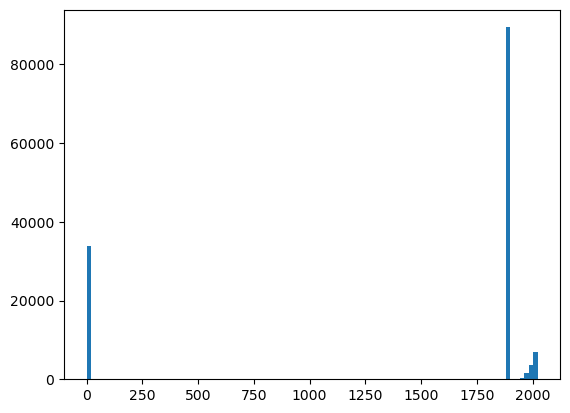

In [16]:
from matplotlib import pyplot as plt

plt.hist(df_pc["hab_construction_an"], bins=100)
plt.show()

Variable pas exploitable.

In [17]:
df_pc.code_epsg.value_counts()

4559    85481
2975    32288
4471    10308
2972     7838
Name: code_epsg, dtype: int64

In [18]:
df_pc.groupby(["dep", "code_epsg"])["id"].count()

dep               code_epsg
Guadeloupe        4559         43248
Guyane            2972          7838
Martinique        4559         36829
Mayotte           4471         10308
Réunion           2975         32288
Saint-Barthélémy  4559          5404
Name: id, dtype: int64

In [19]:
dep_to_epsg = {
    "Guadeloupe": 4559,
    "Guyane": 2972,
    "Martinique": 4559,
    "Mayotte": 4471,
    "Réunion": 2975,
    "Saint-Barthélémy": 4559
}

In [20]:
df_pc.code_ilot.value_counts()

AM01    1615
AW01    1522
AP01    1481
AO01    1370
AM02    1284
        ... 
BP04       1
79         1
BL03       1
BI02       1
AT18       1
Name: code_ilot, Length: 878, dtype: int64

In [21]:
df_pc.grp_rotation.value_counts()

5.0    41419
2.0    33270
4.0    32087
3.0    29124
Name: grp_rotation, dtype: int64

In [22]:
df_pc.groupby(["dep", "grp_rotation"])["id"].count()

dep               grp_rotation
Guadeloupe        2.0              9504
                  3.0             12849
                  4.0             12798
                  5.0              8093
Guyane            2.0              3379
                  3.0              1197
                  4.0              1355
                  5.0              1898
Martinique        2.0              8101
                  3.0              8621
                  4.0              8770
                  5.0             11337
Mayotte           3.0              2539
                  4.0              5137
                  5.0              2632
Réunion           2.0             12286
                  3.0              3918
                  4.0              4027
                  5.0             12055
Saint-Barthélémy  5.0              5404
Name: id, dtype: int64

Le GR 1 a été enquêté à l’EAR 2019 donc son enquête carto a eu lieu de mai à août 2018, ..., GR5 -> EAR 2023 donc enquête carto de mai à août 2022. Avec l’annulation de l’EAR 2021 sauf à Mayotte, les PC (sauf Mayotte) ont été décalées d’un GR, ainsi par exemple les PC du GR3 (EAR 2021 et enquête carto 2020) sont passées dans le GR4 et ont 2 RIL consécutifs (millesimes 2021 et 2022). Certaines PC n’ont pas de RIL. 
J’ai également mis le fichier des contours d’îlots tels qu’ils existent actuellement mais attention les contours d’îlots ont pu changer ces dernières années surtout en Guyane.

In [23]:
df_pc.millesime.value_counts()

2020    40474
2023    35496
2022    31505
2021    28440
Name: millesime, dtype: int64

In [24]:
df_pc[df_pc.millesime == 2020].groupby(["depcom", "grp_rotation"])["id"].count()

depcom  grp_rotation
97119   2.0             3363
        3.0              684
        4.0              582
97130   2.0              658
97131   2.0             1044
97132   2.0             4439
97211   2.0              381
97216   2.0             1489
97218   2.0             2411
97223   2.0             3820
97313   2.0             1420
97357   2.0              679
97360   2.0             1280
97403   2.0             3176
97417   2.0             2336
97419   5.0             2794
97421   2.0             3546
97423   2.0             3228
97424   5.0             3129
Name: id, dtype: int64

Comprendre pourquoi ?

In [25]:
df_pc[df_pc.millesime == 2021].groupby(["depcom", "grp_rotation"])["id"].count()

depcom  grp_rotation
97108   3.0             2516
97109   3.0             3445
97112   3.0             3897
97126   3.0             2307
97202   3.0             2079
97205   3.0             1568
97215   3.0              549
97217   3.0             3545
97219   3.0              880
97303   3.0              783
97361   3.0              414
97406   3.0             3918
97613   3.0             2539
Name: id, dtype: int64

In [26]:
df_pc[df_pc.millesime == 2022].groupby(["depcom", "grp_rotation"])["id"].count()

depcom  grp_rotation
97108   4.0             2517
97109   4.0             3462
97112   4.0             3897
97126   4.0             2340
97202   4.0             2119
97205   4.0             1586
97215   4.0              557
97217   4.0             3627
97219   4.0              881
97303   4.0              795
97361   4.0              560
97406   4.0             4027
97605   4.0             3123
97609   4.0             2014
Name: id, dtype: int64

In [27]:
df_pc[df_pc.millesime == 2023].groupby(["depcom", "grp_rotation"])["id"].count()

depcom  grp_rotation
97102   5.0             3066
97106   5.0             4208
97133   5.0              819
97203   5.0             1801
97204   5.0             1972
97206   5.0             3088
97231   5.0             3535
97233   5.0              941
97301   5.0              398
97308   5.0             1236
97314   5.0               68
97352   5.0              140
97356   5.0               56
97419   5.0             2919
97424   5.0             3213
97612   5.0             2632
97701   5.0             5404
Name: id, dtype: int64

In [28]:
depcom_to_gr_pre_2021 = {
    97119: 2, 
    97130: 2, 
    97131: 2, 
    97132: 2, 
    97211: 2, 
    97216: 2, 
    97218: 2,
    97223: 2, 
    97313: 2, 
    97357: 2, 
    97360: 2, 
    97403: 2, 
    97417: 2, 
    97419: 5, 
    97421: 2, 
    97423: 2,
    97424: 5,
    97108: 3,
    97109: 3,
    97112: 3, 
    97126: 3, 
    97202: 3, 
    97205: 3, 
    97215: 3, 
    97217: 3,
    97219: 3,
    97303: 3,
    97361: 3,
    97406: 3,
    97613: 3
}

depcom_to_gr_post_2021 = {
    97108: 4,
    97109: 4,
    97112: 4,
    97126: 4,
    97202: 4,
    97205: 4,
    97215: 4,
    97217: 4,
    97219: 4,
    97303: 4,
    97361: 4,
    97406: 4,
    97605: 4,
    97609: 4,
    97102: 5,
    97106: 5,
    97133: 5,
    97203: 5,
    97204: 5,
    97206: 5,
    97231: 5,
    97233: 5,
    97301: 5,
    97308: 5,
    97314: 5,
    97352: 5,
    97356: 5,
    97419: 5,
    97424: 5,
    97612: 5,
    97701: 5
}

In [29]:
gr_to_validity = {
    2: ("2019-05", "2019-08"),
    3: ("2020-05", "2020-08"),
    4: ("2021-05", "2021-08"),
    5: ("2022-05", "2022-08")
}

millesime_to_validity = {
    2020: ("2019-05", "2019-08"),
    2021: ("2020-05", "2020-08"),
    2022: ("2021-05", "2021-08"),
    2023: ("2022-05", "2022-08")
}

Il faut choisir ces dates de validité

In [30]:
df_pc.code_ilot.value_counts()

AM01    1615
AW01    1522
AP01    1481
AO01    1370
AM02    1284
        ... 
BP04       1
79         1
BL03       1
BI02       1
AT18       1
Name: code_ilot, Length: 878, dtype: int64

In [31]:
df_pc[df_pc.millesime == 2020].groupby(["depcom", "code_ilot"])["id"].count()

depcom  code_ilot
97119   AB03         114
        AB04          18
        AB05           4
        AB06          62
        AB07           8
                    ... 
97424   AP04          16
        AP05          35
        AP06           4
        AP07          25
        AR06           2
Name: id, Length: 1267, dtype: int64

Utilité des ilots pour les PC ?

## Grandes communes

In [32]:
with fs.open('projet-slums-detection/Donnees/RIL/ril_gc_dom.csv', 'r') as f:
    df_gc = pd.read_csv(f)

/tmp/ipykernel_1733/341672092.py:2: DtypeWarning: Columns (5,9,14,19,20,27,29,36,39,41,42,43) have mixed types. Specify dtype option on import or set low_memory=False.
  df_gc = pd.read_csv(f)


Data types to specify

In [33]:
df_gc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2564120 entries, 0 to 2564119
Data columns (total 51 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   id                      int64  
 1   depcom                  int64  
 2   id_ea                   int64  
 3   principal               object 
 4   numero                  int64  
 5   repetition              object 
 6   complement              object 
 7   type_voie               object 
 8   libelle_voie            object 
 9   rivoli                  object 
 10  ea_type                 object 
 11  hab_hot_type            object 
 12  nb_log                  float64
 13  etat                    float64
 14  pc_num                  object 
 15  commentaire             object 
 16  hab_construction_an     float64
 17  hab_nb_imm              float64
 18  hab_niv                 float64
 19  hot_sous_type           object 
 20  hot_enseigne            object 
 21  lien_cmt                float64

In [34]:
df_gc.head()

,id,depcom,id_ea,principal,numero,repetition,complement,type_voie,libelle_voie,rivoli,ea_type,hab_hot_type,nb_log,etat,pc_num,commentaire,hab_construction_an,hab_nb_imm,hab_niv,hot_sous_type,hot_enseigne,lien_cmt,x,y,code_epsg,type_localisation,numero_parcelle,code_ilot,code_iris,quartier_prioritaire,canton,liste_insee,id_rp,dernier_tirage,echantillon,grp_rotation,date_maj_ea,com_anc_idft,com_type,com_statut,com_nb_log_fonction,com_nom,com_date_creation_base,com_date_fermeture,com_capacite_theorique,millesime,date_livraison,ref_ea,id_rca_adresse,reperage,id_ea_regroup
0,32037034,97101,971010000018000,O,0,NaN,NaN,RTE,DE CADUC,0209,HABIT,0052,0.0,1.0,NaN,NaN,1900.0,0.0,0.0,NaN,NaN,1.0,661399.506,1802848.75,4559,CIC,NaN,AH03,113.0,NaN,2.0,O,97101 AH03 001,NaN,N,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023,2022-10-06 14:06:15.000,12693968,13781464,CHENIL,NaN
1,32037035,97101,971010000016555,O,0,NaN,NaN,RTE,DE CADUC,0209,HABIT,002D,1.0,1.0,NaN,NaN,1900.0,1.0,1.0,NaN,NaN,1.0,662317.510,1802803.62,4559,CIC,NaN,AH04,113.0,NaN,2.0,N,97101 AH04 036,NaN,N,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023,2022-10-06 14:06:15.000,12693993,13781490,EN HAUTEUR MEME ENTREE QUE 020,NaN
2,32037036,97101,971010000016537,O,0,NaN,NaN,RTE,DE CADUC,0209,HABIT,002D,1.0,1.0,NaN,NaN,1900.0,1.0,1.0,NaN,NaN,1.0,662318.385,1802718.25,4559,CIC,NaN,AH04,113.0,NaN,2.0,N,97101 AH04 018,NaN,N,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023,2022-10-06 14:06:15.000,12694053,13781557,TOIT BLEU NUIT,NaN
3,32037037,97101,971010000018082,O,0,NaN,NaN,RTE,DE CADUC,0209,HABIT,0052,0.0,1.0,NaN,NaN,1900.0,0.0,0.0,NaN,NaN,1.0,661443.444,1802703.12,4559,CIC,NaN,AH03,113.0,NaN,2.0,O,97101 AH03 080,NaN,N,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023,2022-10-06 14:06:15.000,12694070,13781574,ATELIZR DE COUTURE,NaN
4,32037038,97101,971010000018023,O,63,NaN,NaN,VOI,VILLAGE CADUC VOIE A,B048,HABIT,002D,1.0,1.0,NaN,NaN,1900.0,1.0,1.0,NaN,NaN,1.0,661537.632,1802589.00,4559,CIC,NaN,AH03,113.0,NaN,2.0,O,97101 AH03 024,NaN,N,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023,2022-10-06 14:06:15.000,12694190,13781695,NaN,NaN


In [35]:
df_gc["dep"] = df_gc["depcom"].astype(str).str[:3]

In [36]:
df_gc.dep.value_counts()

974    1124595
971     590166
972     430787
973     229074
976     147351
978      42147
Name: dep, dtype: int64

In [37]:
df_gc[df_gc.dep == "978"].depcom.value_counts()

97801    42147
Name: depcom, dtype: int64

Que Saint Martin.

In [38]:
dep_mapping = {
    "971": "Guadeloupe",
    "972": "Martinique",
    "973": "Guyane",
    "974": "Réunion",
    "976": "Mayotte",
    "978": "Saint-Martin",
}
df_gc["dep"] = df_gc["dep"].apply(lambda x: dep_mapping[x])
df_gc.head()

,id,depcom,id_ea,principal,numero,repetition,complement,type_voie,libelle_voie,rivoli,ea_type,hab_hot_type,nb_log,etat,pc_num,commentaire,hab_construction_an,hab_nb_imm,hab_niv,hot_sous_type,hot_enseigne,lien_cmt,x,y,code_epsg,type_localisation,numero_parcelle,code_ilot,code_iris,quartier_prioritaire,canton,liste_insee,id_rp,dernier_tirage,echantillon,grp_rotation,date_maj_ea,com_anc_idft,com_type,com_statut,com_nb_log_fonction,com_nom,com_date_creation_base,com_date_fermeture,com_capacite_theorique,millesime,date_livraison,ref_ea,id_rca_adresse,reperage,id_ea_regroup,dep
0,32037034,97101,971010000018000,O,0,NaN,NaN,RTE,DE CADUC,0209,HABIT,0052,0.0,1.0,NaN,NaN,1900.0,0.0,0.0,NaN,NaN,1.0,661399.506,1802848.75,4559,CIC,NaN,AH03,113.0,NaN,2.0,O,97101 AH03 001,NaN,N,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023,2022-10-06 14:06:15.000,12693968,13781464,CHENIL,NaN,Guadeloupe
1,32037035,97101,971010000016555,O,0,NaN,NaN,RTE,DE CADUC,0209,HABIT,002D,1.0,1.0,NaN,NaN,1900.0,1.0,1.0,NaN,NaN,1.0,662317.510,1802803.62,4559,CIC,NaN,AH04,113.0,NaN,2.0,N,97101 AH04 036,NaN,N,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023,2022-10-06 14:06:15.000,12693993,13781490,EN HAUTEUR MEME ENTREE QUE 020,NaN,Guadeloupe
2,32037036,97101,971010000016537,O,0,NaN,NaN,RTE,DE CADUC,0209,HABIT,002D,1.0,1.0,NaN,NaN,1900.0,1.0,1.0,NaN,NaN,1.0,662318.385,1802718.25,4559,CIC,NaN,AH04,113.0,NaN,2.0,N,97101 AH04 018,NaN,N,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023,2022-10-06 14:06:15.000,12694053,13781557,TOIT BLEU NUIT,NaN,Guadeloupe
3,32037037,97101,971010000018082,O,0,NaN,NaN,RTE,DE CADUC,0209,HABIT,0052,0.0,1.0,NaN,NaN,1900.0,0.0,0.0,NaN,NaN,1.0,661443.444,1802703.12,4559,CIC,NaN,AH03,113.0,NaN,2.0,O,97101 AH03 080,NaN,N,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023,2022-10-06 14:06:15.000,12694070,13781574,ATELIZR DE COUTURE,NaN,Guadeloupe
4,32037038,97101,971010000018023,O,63,NaN,NaN,VOI,VILLAGE CADUC VOIE A,B048,HABIT,002D,1.0,1.0,NaN,NaN,1900.0,1.0,1.0,NaN,NaN,1.0,661537.632,1802589.00,4559,CIC,NaN,AH03,113.0,NaN,2.0,O,97101 AH03 024,NaN,N,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023,2022-10-06 14:06:15.000,12694190,13781695,NaN,NaN,Guadeloupe


In [39]:
df_gc.ea_type.value_counts()

HABIT    2560736
COMMU       2312
HOTEL       1072
Name: ea_type, dtype: int64

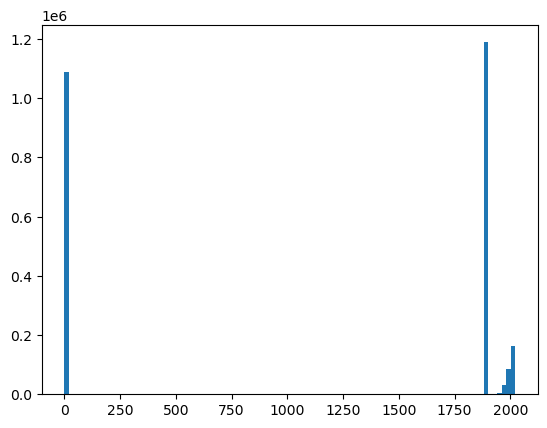

In [40]:
from matplotlib import pyplot as plt

plt.hist(df_gc["hab_construction_an"], bins=100)
plt.show()

Variable pas exploitable.

In [41]:
df_gc.code_epsg.value_counts()

2975    1124595
4559    1063100
2972     229074
4471     147351
Name: code_epsg, dtype: int64

In [42]:
df_gc.groupby(["dep", "code_epsg"])["id"].count()

dep           code_epsg
Guadeloupe    4559          590166
Guyane        2972          229074
Martinique    4559          430787
Mayotte       4471          147351
Réunion       2975         1124595
Saint-Martin  4559           42147
Name: id, dtype: int64

In [43]:
dep_to_epsg = {
    "Guadeloupe": 4559,
    "Guyane": 2972,
    "Martinique": 4559,
    "Mayotte": 4471,
    "Réunion": 2975,
    "Saint-Martin": 4559
}

In [44]:
df_gc.code_ilot.value_counts()

AP02    8425
AV02    8160
AT01    7747
AH01    7681
AR03    7489
        ... 
DA03       1
0093       1
BX24       1
0092       1
HP11       1
Name: code_ilot, Length: 3965, dtype: int64

In [45]:
df_gc.grp_rotation.value_counts()

4.0    520053
2.0    517546
3.0    512889
5.0    510026
1.0    503431
Name: grp_rotation, dtype: int64

In [46]:
df_gc.groupby(["dep", "grp_rotation"])["id"].count()

dep           grp_rotation
Guadeloupe    1.0             112340
              2.0             118909
              3.0             113008
              4.0             125943
              5.0             119941
Guyane        1.0              43549
              2.0              47082
              3.0              50125
              4.0              43663
              5.0              44626
Martinique    1.0              84938
              2.0              88261
              3.0              85325
              4.0              88723
              5.0              83534
Mayotte       1.0              27643
              2.0              28197
              3.0              31223
              4.0              29992
              5.0              30296
Réunion       1.0             226337
              2.0             224949
              3.0             226388
              4.0             222730
              5.0             224093
Saint-Martin  1.0               8624
           

In [47]:
df_gc.millesime.value_counts()

2023    677500
2022    662887
2021    644992
2020    578741
Name: millesime, dtype: int64

In [48]:
df_gc[df_gc.millesime == 2020].groupby(["depcom", "grp_rotation"])["id"].count()

depcom  grp_rotation
97101   1.0             4220
        2.0             4769
        3.0             4729
        4.0             4729
        5.0             4521
                        ... 
97801   1.0             2156
        2.0             2530
        3.0             1654
        4.0             2213
        5.0             1888
Name: id, Length: 255, dtype: int64

Pour les GC on a pour 1 millesime plusieurs groupes de rotation dans la base.

In [49]:
df_gc[df_gc.millesime == 2021].groupby(["depcom", "grp_rotation"])["id"].count()

depcom  grp_rotation
97101   1.0             4224
        2.0             4780
        3.0             4941
        4.0             4731
        5.0             4523
                        ... 
97801   1.0             2156
        2.0             2539
        3.0             1722
        4.0             2215
        5.0             1890
Name: id, Length: 310, dtype: int64

In [50]:
df_gc[df_gc.millesime == 2022].groupby(["depcom", "grp_rotation"])["id"].count()

depcom  grp_rotation
97101   1.0             4245
        2.0             4801
        3.0             4952
        4.0             4915
        5.0             4540
                        ... 
97801   1.0             2156
        2.0             2539
        3.0             1722
        4.0             2287
        5.0             1846
Name: id, Length: 310, dtype: int64

In [51]:
df_gc[df_gc.millesime == 2023].groupby(["depcom", "grp_rotation"])["id"].count()

depcom  grp_rotation
97101   1.0             4288
        2.0             4827
        3.0             4983
        4.0             4937
        5.0             4766
                        ... 
97801   1.0             2156
        2.0             2540
        3.0             1722
        4.0             2287
        5.0             1912
Name: id, Length: 310, dtype: int64

Ilots ? normalement 1 groupe de rotation par ilot ? 

In [52]:
df_gc[df_gc.millesime == 2020].groupby(["code_ilot", "grp_rotation"])["id"].count()

code_ilot  grp_rotation
10         1.0              30
           2.0              71
           3.0              35
           4.0             106
           5.0              18
                          ... 
PED6       4.0             261
           5.0             105
PED7       3.0             187
           5.0             146
PED8       3.0              90
Name: id, Length: 8290, dtype: int64

Par ilot et commune ? 

In [53]:
df_gc[df_gc.millesime == 2020].groupby(["depcom", "code_ilot", "grp_rotation"])["id"].count()

depcom  code_ilot  grp_rotation
97101   AB01       3.0              10
                   5.0             104
        AB02       1.0              24
        AB03       2.0               6
        AB04       3.0               7
                                  ... 
97801   BV01       2.0              84
        BV02       1.0              71
        BV03       3.0              48
        BV04       5.0              97
        BV05       1.0             101
Name: id, Length: 14114, dtype: int64

Nombre de groupes de rotations différents par commune x ilot

In [54]:
nb_grp_rotation = df_gc[df_gc.millesime == 2020].groupby(["depcom", "code_ilot", "grp_rotation"])["id"].count().reset_index().groupby(["depcom", "code_ilot"])["grp_rotation"].count()

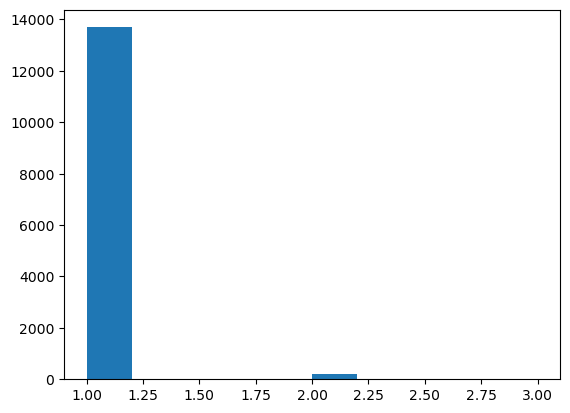

In [55]:
plt.hist(nb_grp_rotation)
plt.show()

In [56]:
nb_grp_rotation.value_counts()

1    13697
2      192
3       11
Name: grp_rotation, dtype: int64

On est très souvent à 1 groupe de rotation par commune x ilot

In [57]:
df_gc.millesime.value_counts()

2023    677500
2022    662887
2021    644992
2020    578741
Name: millesime, dtype: int64

In [58]:
millesime_to_validity = {
    2020: ("2019-05", "2019-08"),
    2021: ("2020-05", "2020-08"),
    2022: ("2021-05", "2021-08"),
    2023: ("2022-05", "2022-08")
}

Il faut choisir ces dates de validité

## Géométrie ilots

In [59]:
!pip install pyreadr

In [60]:
import pyreadr

fs.get('projet-slums-detection/Donnees/RIL/rca_geometry_ilots.rds', 'rca_geometry_ilots.rds')
result = pyreadr.read_r('rca_geometry_ilots.rds')

In [61]:
result.keys()

odict_keys([None])

In [62]:
df_geom = result[None] 

In [63]:
type(df_geom)

pandas.core.frame.DataFrame

In [64]:
df_geom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20266 entries, 0 to 20265
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   depcom     20266 non-null  object
 1   gr         20266 non-null  object
 2   code_ilot  20266 non-null  object
 3   wkt        20266 non-null  object
 4   srid       20266 non-null  int32 
dtypes: int32(1), object(4)
memory usage: 712.6+ KB


In [65]:
df_geom.head()

,depcom,gr,code_ilot,wkt,srid
0,97422,3,DL06,"MULTIPOLYGON(((55.56002787 -21.22882749,55.561...",4326
1,97422,1,CX04,"MULTIPOLYGON(((55.52972332 -21.19910885,55.529...",4326
2,97405,2,AB01,"MULTIPOLYGON(((55.59368481 -21.2903575,55.5948...",4326
3,97405,4,AB02,"MULTIPOLYGON(((55.58635546 -21.31395429,55.586...",4326
4,97418,5,AV19,"MULTIPOLYGON(((55.51758202 -20.91979163,55.518...",4326


In [66]:
df_geom.depcom.str[:3].value_counts()

974    9851
972    4230
971    2931
973    2217
976     811
978     150
977      76
Name: depcom, dtype: int64

In [67]:
df_geom.srid.value_counts()

4326    20266
Name: srid, dtype: int64

In [68]:
from shapely import wkt

df_geom['wkt'] = df_geom['wkt'].apply(wkt.loads)

In [69]:
import geopandas as gpd

gdf = gpd.GeoDataFrame(df_geom, geometry="wkt", crs="EPSG:4326")
gdf

,depcom,gr,code_ilot,wkt,srid
0,97422,3,DL06,"MULTIPOLYGON (((55.56003 -21.22883, 55.56142 -...",4326
1,97422,1,CX04,"MULTIPOLYGON (((55.52972 -21.19911, 55.52997 -...",4326
2,97405,2,AB01,"MULTIPOLYGON (((55.59368 -21.29036, 55.59485 -...",4326
3,97405,4,AB02,"MULTIPOLYGON (((55.58636 -21.31395, 55.58649 -...",4326
4,97418,5,AV19,"MULTIPOLYGON (((55.51758 -20.91979, 55.51887 -...",4326
...,...,...,...,...,...
20261,97701,5,AX04,"MULTIPOLYGON (((-62.80733 17.90321, -62.80724 ...",4326
20262,97701,5,AX05,"MULTIPOLYGON (((-62.80163 17.90505, -62.80102 ...",4326
20263,97701,5,AX06,"MULTIPOLYGON (((-62.80623 17.90211, -62.80599 ...",4326
20264,97701,5,AX07,"MULTIPOLYGON (((-62.81270 17.90598, -62.81263 ...",4326


In [70]:
gdf.geometry

0        MULTIPOLYGON (((55.56003 -21.22883, 55.56142 -...
1        MULTIPOLYGON (((55.52972 -21.19911, 55.52997 -...
2        MULTIPOLYGON (((55.59368 -21.29036, 55.59485 -...
3        MULTIPOLYGON (((55.58636 -21.31395, 55.58649 -...
4        MULTIPOLYGON (((55.51758 -20.91979, 55.51887 -...
                               ...                        
20261    MULTIPOLYGON (((-62.80733 17.90321, -62.80724 ...
20262    MULTIPOLYGON (((-62.80163 17.90505, -62.80102 ...
20263    MULTIPOLYGON (((-62.80623 17.90211, -62.80599 ...
20264    MULTIPOLYGON (((-62.81270 17.90598, -62.81263 ...
20265    MULTIPOLYGON (((-63.03229 18.09875, -63.03253 ...
Name: wkt, Length: 20266, dtype: geometry

In [71]:
gdf.groupby(["depcom", "code_ilot"])["srid"].count()

depcom  code_ilot
97101   AB01         1
        AB02         1
        AB03         1
        AB04         1
        AB05         1
                    ..
97801   BV01         1
        BV02         1
        BV03         1
        BV04         1
        BV05         1
Name: srid, Length: 20266, dtype: int64

On a bien que des depcom x ilot distincts

## Save as partitionned_parquet file

In [72]:
with fs.open('projet-slums-detection/Donnees/RIL/ril_pc_dom.csv', 'r') as f:
    df_pc = pd.read_csv(f, dtype={
        "id": str,
        "depcom": str,
        "ea_type": str,
        "nb_log": pd.Int64Dtype(),
        "hab_construction_an": pd.Int64Dtype(),
        "x": float,
        "y": float,
        "code_epsg": str,
        "code_ilot": str,
        "grp_rotation": pd.Int64Dtype(),
        "millesime": pd.Int64Dtype(),
        "date_livraison": object,
        "reperage": str
    })

/tmp/ipykernel_1733/2697064054.py:2: DtypeWarning: Columns (5,9,14,19,20,29,36,43) have mixed types. Specify dtype option on import or set low_memory=False.
  df_pc = pd.read_csv(f, dtype={


In [73]:
df_pc = df_pc[["id", "depcom", "ea_type", "nb_log", "hab_construction_an", "x", "y", "code_epsg", "code_ilot", "grp_rotation", "millesime", "date_livraison", "reperage"]]

In [74]:
df_pc.head()

,id,depcom,ea_type,nb_log,hab_construction_an,x,y,code_epsg,code_ilot,grp_rotation,millesime,date_livraison,reperage
0,32033149,97102,HABIT,0,1900,663634.543,1825946.61,4559,PED1,5,2023,2022-10-05 16:41:04.000,COMMERCES
1,32033150,97102,HABIT,1,1900,662540.599,1825264.35,4559,PED1,5,2023,2022-10-05 16:41:04.000,PORTAIL VERT / TOIT BLC
2,32033151,97102,HABIT,6,1900,662512.349,1825143.23,4559,PED1,5,2023,2022-10-05 16:41:04.000,ACCES CHEM GITES
3,32033152,97102,HABIT,1,1900,662573.224,1825054.98,4559,PED1,5,2023,2022-10-05 16:41:04.000,MAISON JAUNE /TOIT BLEU
4,32033153,97102,HABIT,1,1900,662645.662,1824859.98,4559,PED1,5,2023,2022-10-05 16:41:04.000,ACCES CHEM


In [75]:
with fs.open('projet-slums-detection/Donnees/RIL/ril_gc_dom.csv', 'r') as f:
    df_gc = pd.read_csv(f, dtype={
        "id": str,
        "depcom": str,
        "ea_type": str,
        "nb_log": pd.Int64Dtype(),
        "hab_construction_an": pd.Int64Dtype(),
        "x": float,
        "y": float,
        "code_epsg": str,
        "code_ilot": str,
        "grp_rotation": pd.Int64Dtype(),
        "millesime": pd.Int64Dtype(),
        "date_livraison": object,
        "reperage": str
    })

/tmp/ipykernel_1733/3882058059.py:2: DtypeWarning: Columns (5,9,14,19,20,29,36,39,41,42,43) have mixed types. Specify dtype option on import or set low_memory=False.
  df_gc = pd.read_csv(f, dtype={


In [76]:
df_gc = df_gc[["id", "depcom", "ea_type", "nb_log", "hab_construction_an", "x", "y", "code_epsg", "code_ilot", "grp_rotation", "millesime", "date_livraison", "reperage"]]

In [77]:
df_pc["type_com"] = "pc"
df_gc["type_com"] = "gc"

In [78]:
df_ril = pd.concat([df_gc, df_pc])
df_ril.head()

,id,depcom,ea_type,nb_log,hab_construction_an,x,y,code_epsg,code_ilot,grp_rotation,millesime,date_livraison,reperage,type_com
0,32037034,97101,HABIT,0,1900,661399.506,1802848.75,4559,AH03,5,2023,2022-10-06 14:06:15.000,CHENIL,gc
1,32037035,97101,HABIT,1,1900,662317.510,1802803.62,4559,AH04,4,2023,2022-10-06 14:06:15.000,EN HAUTEUR MEME ENTREE QUE 020,gc
2,32037036,97101,HABIT,1,1900,662318.385,1802718.25,4559,AH04,4,2023,2022-10-06 14:06:15.000,TOIT BLEU NUIT,gc
3,32037037,97101,HABIT,0,1900,661443.444,1802703.12,4559,AH03,5,2023,2022-10-06 14:06:15.000,ATELIZR DE COUTURE,gc
4,32037038,97101,HABIT,1,1900,661537.632,1802589.00,4559,AH03,5,2023,2022-10-06 14:06:15.000,NaN,gc


In [79]:
df_ril.shape

(2700035, 14)

In [80]:
df_ril["dep"] = df_ril["depcom"].str[:3]
df_ril.head()

,id,depcom,ea_type,nb_log,hab_construction_an,x,y,code_epsg,code_ilot,grp_rotation,millesime,date_livraison,reperage,type_com,dep
0,32037034,97101,HABIT,0,1900,661399.506,1802848.75,4559,AH03,5,2023,2022-10-06 14:06:15.000,CHENIL,gc,971
1,32037035,97101,HABIT,1,1900,662317.510,1802803.62,4559,AH04,4,2023,2022-10-06 14:06:15.000,EN HAUTEUR MEME ENTREE QUE 020,gc,971
2,32037036,97101,HABIT,1,1900,662318.385,1802718.25,4559,AH04,4,2023,2022-10-06 14:06:15.000,TOIT BLEU NUIT,gc,971
3,32037037,97101,HABIT,0,1900,661443.444,1802703.12,4559,AH03,5,2023,2022-10-06 14:06:15.000,ATELIZR DE COUTURE,gc,971
4,32037038,97101,HABIT,1,1900,661537.632,1802589.00,4559,AH03,5,2023,2022-10-06 14:06:15.000,NaN,gc,971


In [ ]:
import pyarrow.parquet as pq
import pyarrow as pa

def write_parquet_as_partitioned_dataset(fs, table, endpoint, bucket_name, path, partition_cols=None, compression="SNAPPY"):
    url = f"https://{endpoint}"
    file_uri = f"{bucket_name}/{path}"
    pq.write_to_dataset(table, root_path=file_uri, partition_cols=partition_cols, filesystem=fs, compression=compression)

In [ ]:
endpoint = os.environ['AWS_S3_ENDPOINT']
bucket_name = "projet-slums-detection"
path = "Donnees/RIL/ril_data.parquet"

In [ ]:
table_ril = pa.Table.from_pandas(df_ril)

In [ ]:
write_parquet_as_partitioned_dataset(fs, table_ril, endpoint, bucket_name, path, partition_cols=["dep", "millesime"])

## Function to get a RIL file

In [81]:
!pip install affine
!pip install rasterio

In [82]:
import pyarrow.parquet as pq
import pyarrow as pa

In [83]:
dep_to_crs = {
    "971": "4559",
    "973": "2972",
    "972": "4559",
    "976": "4471",
    "974": "2975",
    "977": "4559",
    "978": "4559"
}

In [84]:
import sys
sys.path.append("../src/")
from utils import get_environment, get_file_system
from typing import Literal
from datetime import datetime

def load_ril(millesime: Literal["2020", "2021", "2022", "2023"], dep: Literal["971", "972", "973", "974", "976", "977", "978"]) -> gpd.GeoDataFrame:
    """
    Load RIL for a given datetime.

    Args:
        millesime (Literal): Year.
        dep (Literal): Departement.

    Returns:
        gpd.GeoDataFrame: RIL GeoDataFrame.
    """
    environment = get_environment()
    fs = get_file_system()
    
    dataset = pq.ParquetDataset(
        os.path.join(
            environment["bucket"], environment["sources"]["RIL"], "dep=" + dep, "millesime=" + millesime
        ),
        filesystem=fs
    )
    
    df = dataset.read().to_pandas()
    gdf = gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df.x, df.y)
    )
    crs = dep_to_crs[dep]
    gdf = gdf.set_crs("epsg:" + crs)
    
    return gdf

In [85]:
a = load_ril("2020", "971")

In [86]:
a

,id,depcom,ea_type,nb_log,hab_construction_an,x,y,code_epsg,code_ilot,grp_rotation,date_livraison,reperage,type_com,geometry
131072,7334975,97103,HABIT,1,1900,648366.501,1796739.98,4559,BE04,5,2019-10-09 18:19:21.000,None,gc,POINT (648366.501 1796739.980)
131073,7334976,97103,HABIT,0,1900,654324.903,1795684.72,4559,AM11,2,2019-10-09 18:19:21.000,CLINIQUE VETERINAIRE,gc,POINT (654324.903 1795684.720)
131074,7334977,97103,HABIT,1,1900,650552.826,1798771.61,4559,AC02,2,2019-10-09 18:19:21.000,None,gc,POINT (650552.826 1798771.610)
131075,7334978,97103,HABIT,1,1900,648539.189,1796428.48,4559,BE02,2,2019-10-09 18:19:21.000,VILLA FLAMBOYANT,gc,POINT (648539.189 1796428.480)
131076,7334979,97103,HABIT,1,1900,649134.942,1796785.11,4559,AY03,1,2019-10-09 18:19:21.000,None,gc,POINT (649134.942 1796785.110)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42424,7544246,97132,HABIT,1,1900,647154.842,1768988.10,4559,AC01,2,2019-10-17 15:24:19.000,None,pc,POINT (647154.842 1768988.100)
42425,7544247,97132,HABIT,1,1900,644155.326,1767148.22,4559,AV01,2,2019-10-17 15:24:19.000,TOIT VERT FONCE BARRIERE BLANCHE SUR LA ROUTE,pc,POINT (644155.326 1767148.220)
42426,7544248,97132,HABIT,1,1900,644296.389,1767126.72,4559,AV01,2,2019-10-17 15:24:19.000,EN ABRICOT ET BLANC,pc,POINT (644296.389 1767126.720)
42427,7544249,97132,HABIT,1,1900,642589.943,1765844.22,4559,AR02,2,2019-10-17 15:24:19.000,None,pc,POINT (642589.943 1765844.220)


## Nécessaire pour les fonctions de filtre

In [87]:
fs.get('projet-slums-detection/Donnees/RIL/rca_geometry_ilots.rds', 'rca_geometry_ilots.rds')
result = pyreadr.read_r('rca_geometry_ilots.rds')

In [88]:
result.keys()

odict_keys([None])

In [89]:
df_geom = result[None] 

In [90]:
type(df_geom)

pandas.core.frame.DataFrame

In [91]:
df_geom['wkt'] = df_geom['wkt'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(df_geom, geometry="wkt", crs="EPSG:4326")
gdf

,depcom,gr,code_ilot,wkt,srid
0,97422,3,DL06,"MULTIPOLYGON (((55.56003 -21.22883, 55.56142 -...",4326
1,97422,1,CX04,"MULTIPOLYGON (((55.52972 -21.19911, 55.52997 -...",4326
2,97405,2,AB01,"MULTIPOLYGON (((55.59368 -21.29036, 55.59485 -...",4326
3,97405,4,AB02,"MULTIPOLYGON (((55.58636 -21.31395, 55.58649 -...",4326
4,97418,5,AV19,"MULTIPOLYGON (((55.51758 -20.91979, 55.51887 -...",4326
...,...,...,...,...,...
20261,97701,5,AX04,"MULTIPOLYGON (((-62.80733 17.90321, -62.80724 ...",4326
20262,97701,5,AX05,"MULTIPOLYGON (((-62.80163 17.90505, -62.80102 ...",4326
20263,97701,5,AX06,"MULTIPOLYGON (((-62.80623 17.90211, -62.80599 ...",4326
20264,97701,5,AX07,"MULTIPOLYGON (((-62.81270 17.90598, -62.81263 ...",4326


In [92]:
gdf.iloc[-3:, :].dissolve(by="gr")

,wkt,depcom,code_ilot,srid
gr,,,,
2,"POLYGON ((-63.03229 18.09875, -63.03253 18.098...",97801,AT01,4326
5,"POLYGON ((-62.80599 17.90204, -62.80576 17.901...",97701,AX06,4326


Warning, les ilots changent en Guyane, là on a des ilots statiques

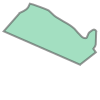

In [93]:
gdf.wkt.iloc[-3]

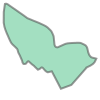

In [94]:
gdf.wkt.iloc[-2]

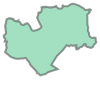

In [95]:
gdf.wkt.iloc[-1]

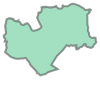

In [96]:
gdf.iloc[-3:, :].dissolve(by="gr").wkt[0]

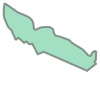

In [97]:
gdf.iloc[-3:, :].dissolve(by="gr").wkt[1]

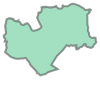

In [98]:
gdf.iloc[-100:, :].dissolve(by="gr").wkt[0]

In [99]:
gdf.iloc[-736:, :].dissolve(by="gr")

,wkt,depcom,code_ilot,srid
gr,,,,
1,"MULTIPOLYGON (((-61.01182 14.61412, -61.01153 ...",97213,0723,4326
2,"MULTIPOLYGON (((-61.02822 14.60984, -61.02829 ...",97213,0701,4326
3,"MULTIPOLYGON (((-61.02920 14.61060, -61.02943 ...",97213,0811,4326
4,"MULTIPOLYGON (((-61.21350 14.78299, -61.21351 ...",97202,0168,4326
5,"MULTIPOLYGON (((-61.17904 14.69840, -61.17909 ...",97306,RN16,4326


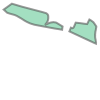

In [100]:
gdf.iloc[-737, :].wkt.buffer(0)

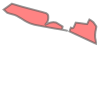

In [101]:
gdf.iloc[-737, :].wkt

In [102]:
gdf.iloc[-737, :].loc["wkt"] = gdf.iloc[-737, :].wkt.buffer(0)

/tmp/ipykernel_1733/587084125.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdf.iloc[-737, :].loc["wkt"] = gdf.iloc[-737, :].wkt.buffer(0)


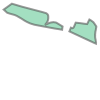

In [103]:
gdf.iloc[-737, :].loc["wkt"].buffer(0)

In [104]:
a = gdf.iloc[-737:-735, :].copy()

In [105]:
a

,depcom,gr,code_ilot,wkt,srid
19529,97311,2,AW01,"MULTIPOLYGON (((-53.93034 5.47453, -53.93031 5...",4326
19530,97306,5,RN16,"MULTIPOLYGON (((-53.92764 5.47664, -53.92873 5...",4326


In [106]:
b = a.copy()

In [107]:
b["wkt"] = [geom.buffer(0) for geom in b["wkt"]]

In [108]:
b

,depcom,gr,code_ilot,wkt,srid
19529,97311,2,AW01,"MULTIPOLYGON (((-53.93034 5.47453, -53.93031 5...",4326
19530,97306,5,RN16,"POLYGON ((-53.93629 5.47919, -53.93594 5.47946...",4326


In [109]:
gdf["wkt"] = [geom.buffer(0) for geom in gdf["wkt"]]

In [110]:
gdf.dissolve(by="gr")

,wkt,depcom,code_ilot,srid
gr,,,,
1,"MULTIPOLYGON (((-61.72288 15.99018, -61.72282 ...",97422,CX04,4326
2,"MULTIPOLYGON (((-61.72490 15.98737, -61.72493 ...",97405,AB01,4326
3,"MULTIPOLYGON (((-61.62250 15.85324, -61.62251 ...",97422,DL06,4326
4,"MULTIPOLYGON (((-61.66700 15.98766, -61.66695 ...",97405,AB02,4326
5,"MULTIPOLYGON (((-61.70326 15.94898, -61.70332 ...",97418,AV19,4326


Compute intersection between image and polygon

En fait là on a un problème, déjà il faut séparer en fonction du département.

In [111]:
def compute_gr_geometry(dep):
    fs.get('projet-slums-detection/Donnees/RIL/rca_geometry_ilots.rds', 'rca_geometry_ilots.rds')
    result = pyreadr.read_r('rca_geometry_ilots.rds')
    df_geom = result[None]
    df_geom['wkt'] = df_geom['wkt'].apply(wkt.loads)
    gdf = gpd.GeoDataFrame(df_geom, geometry="wkt", crs="EPSG:4326")
    gdf["dep"] = gdf.depcom.str[:3]
    gdf = gdf[gdf.dep == dep]
    
    return gdf.dissolve(by="gr").to_crs("epsg:" + dep_to_crs[dep])

In [112]:
guad_geoms = compute_gr_geometry("971")

In [113]:
guad_geoms.crs

<Derived Projected CRS: EPSG:4559>
Name: RRAF 1991 / UTM zone 20N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: French Antilles onshore and offshore west of 60°W - Guadeloupe (including Grande Terre, Basse Terre, Marie Galante, Les Saintes, Iles de la Petite Terre, La Desirade); Martinique; St Barthélemy; northern St Martin.
- bounds: (-63.66, 14.08, -60.0, 18.31)
Coordinate Operation:
- name: UTM zone 20N
- method: Transverse Mercator
Datum: Reseau de Reference des Antilles Francaises 1991
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [114]:
guad_geoms

,wkt,depcom,code_ilot,srid,dep
gr,,,,,
1,"MULTIPOLYGON (((634541.286 1769980.752, 634547...",97101,CY03,4326,971
2,"MULTIPOLYGON (((634644.412 1769874.001, 634659...",97105,AN06,4326,971
3,"MULTIPOLYGON (((642361.942 1765135.972, 642347...",97101,CY04,4326,971
4,"MULTIPOLYGON (((640195.746 1766431.480, 640188...",97101,CY05,4326,971
5,"MULTIPOLYGON (((636327.105 1768179.117, 636331...",97101,CY02,4326,971


Intersection with an image.

In [115]:
!pip install py7zr
!pip install torch

In [116]:
import sys
sys.path.append('../src')
import shutil
import yaml
import py7zr
import os
import s3fs
from satellite_image import SatelliteImage
from labeler import RILLabeler
from labeler import BDTOPOLabeler
from labeled_satellite_image import SegmentationLabeledSatelliteImage
from utils import *
from filter import *
import matplotlib.pyplot as plt
import numpy as np
import rasterio.plot as rp
import re
from datetime import datetime
from tqdm import tqdm

## Téléchargement des données Pléiades

In [117]:
environment = get_environment()

bucket = environment["bucket"]
path_s3_pleiades_data = environment["sources"]["PLEIADES"]
path_s3_bdtopo_data = environment["sources"]["BDTOPO"][2022]["guyane"]
path_local_pleiades_data = environment["local-path"]["PLEIADES"]
path_local_bdtopo_data = environment["local-path"]["BDTOPO"][2022]["guyane"]

fs = s3fs.S3FileSystem(client_kwargs={"endpoint_url": "https://minio.lab.sspcloud.fr"},
                       key=os.environ["AWS_ACCESS_KEY_ID"],
                       secret=os.environ["AWS_SECRET_ACCESS_KEY"])

In [118]:
fs.download(
    rpath=f"{bucket}/{path_s3_pleiades_data}",
    lpath=f"../{path_local_pleiades_data}",
    recursive=True
)

## Découpage et filtrage des images

In [119]:
import re
from tqdm import tqdm

In [120]:
images_paths = [f"../{path_local_pleiades_data}/16bits/ORT_2022072050325085_U22N/" + p for p in os.listdir(f"../{path_local_pleiades_data}/16bits/ORT_2022072050325085_U22N/")]

In [121]:
date = datetime.strptime(re.search(r'ORT_(\d{8})', images_paths[0]).group(1), '%Y%m%d')

On importes les `SatelliteImage` dans une liste.

In [122]:
list_images = [
     SatelliteImage.from_raster(
        filename,
        date = datetime.strptime(re.search(r'ORT_(\d{8})', filename).group(1), '%Y%m%d'),
        dep = "973",
        n_bands = 4
    ) for filename in tqdm(images_paths[:3])]

100%|██████████| 3/3 [00:00<00:00,  6.13it/s]


In [123]:
list_images[0]

In [124]:
list_images[0].__dict__

{'array': array([[[  0,   0,   0, ..., 399, 398, 397],
         [  0,   0,   0, ..., 397, 397, 397],
         [  0,   0,   0, ..., 394, 394, 397],
         ...,
         [  0,   0,   0, ..., 394, 394, 393],
         [  0,   0,   0, ..., 393, 393, 393],
         [  0,   0,   0, ..., 391, 393, 394]],
 
        [[  0,   0,   0, ..., 580, 578, 577],
         [  0,   0,   0, ..., 577, 577, 577],
         [  0,   0,   0, ..., 572, 572, 577],
         ...,
         [  0,   0,   0, ..., 575, 575, 573],
         [  0,   0,   0, ..., 574, 573, 573],
         [  0,   0,   0, ..., 571, 574, 575]],
 
        [[  0,   0,   0, ..., 624, 622, 621],
         [  0,   0,   0, ..., 621, 621, 621],
         [  0,   0,   0, ..., 616, 616, 621],
         ...,
         [  0,   0,   0, ..., 619, 619, 617],
         [  0,   0,   0, ..., 617, 617, 617],
         [  0,   0,   0, ..., 614, 617, 619]],
 
        [[  0,   0,   0, ..., 153, 153, 152],
         [  0,   0,   0, ..., 152, 152, 152],
         [  0,   0, 

In [125]:
list_images[0].bounds

BoundingBox(left=348000.0, bottom=547000.0, right=349000.0, top=548000.0)

In [126]:
xmin, ymin, xmax, ymax = list_images[0].bounds
xmin

348000.0

In [127]:
def compute_gr_geometry(dep):
    fs.get('projet-slums-detection/Donnees/RIL/rca_geometry_ilots.rds', 'rca_geometry_ilots.rds')
    result = pyreadr.read_r('rca_geometry_ilots.rds')
    df_geom = result[None]
    df_geom['wkt'] = df_geom['wkt'].apply(wkt.loads)
    gdf = gpd.GeoDataFrame(df_geom, geometry="wkt", crs="EPSG:4326")
    gdf["dep"] = gdf.depcom.str[:3]
    gdf = gdf[gdf.dep == dep]
    gdf["wkt"] = [geom.buffer(0) for geom in gdf["wkt"]]
    
    return gdf.dissolve(by="gr").to_crs("epsg:" + dep_to_crs[dep])

In [128]:
dep_to_crs

{'971': '4559',
 '973': '2972',
 '972': '4559',
 '976': '4471',
 '974': '2975',
 '977': '4559',
 '978': '4559'}

In [129]:
guy_geoms = compute_gr_geometry("973")
guy_geoms

,wkt,depcom,code_ilot,srid,dep
gr,,,,,
1,"MULTIPOLYGON (((163501.482 402637.630, 163497....",97304,AX11,4326,973
2,"MULTIPOLYGON (((147995.800 356909.800, 148003....",97304,AW12,4326,973
3,"MULTIPOLYGON (((141333.070 469731.718, 142269....",97307,AE12,4326,973
4,"MULTIPOLYGON (((168322.432 404663.093, 168467....",97361,AC03,4326,973
5,"MULTIPOLYGON (((166946.715 380525.424, 167399....",97311,PE10,4326,973


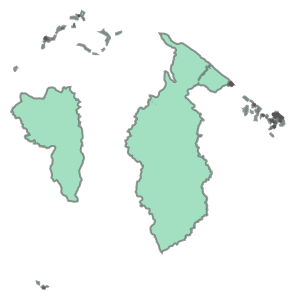

In [130]:
guy_geoms.wkt[0]

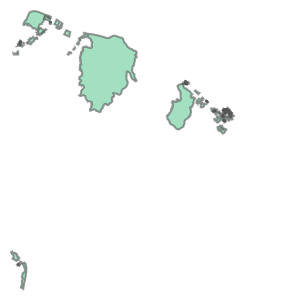

In [131]:
guy_geoms.wkt[3]

In [132]:
guy_geoms.cx[xmin:xmax, ymin:ymax]

,wkt,depcom,code_ilot,srid,dep
gr,,,,,


In [133]:
xmin, ymin, xmax, ymax = list_images[1].bounds
xmin

361000.0

In [134]:
guy_geoms.cx[xmin:xmax, ymin:ymax]

,wkt,depcom,code_ilot,srid,dep
gr,,,,,
2,"MULTIPOLYGON (((147995.800 356909.800, 148003....",97304,AW12,4326,973


In [135]:
guy_geoms.wkt

gr
1    MULTIPOLYGON (((163501.482 402637.630, 163497....
2    MULTIPOLYGON (((147995.800 356909.800, 148003....
3    MULTIPOLYGON (((141333.070 469731.718, 142269....
4    MULTIPOLYGON (((168322.432 404663.093, 168467....
5    MULTIPOLYGON (((166946.715 380525.424, 167399....
Name: wkt, dtype: geometry

In [136]:
guy_geoms.cx[xmin:xmax, ymin:ymax].wkt.area

gr
2    6.793884e+09
dtype: float64

In [137]:
list_images[1].bounds

BoundingBox(left=361000.0, bottom=536000.0, right=362000.0, top=537000.0)

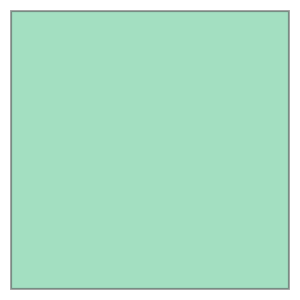

In [138]:
from shapely.geometry import box

geom = box(*list_images[1].bounds)
geom

In [139]:
gpd.GeoDataFrame(gpd.GeoSeries(geom), columns=['geometry']).set_crs("epsg:2972")

,geometry
0,"POLYGON ((362000.000 536000.000, 362000.000 53..."


In [140]:
gpd.overlay(guy_geoms, gpd.GeoDataFrame(gpd.GeoSeries(geom), columns=['geometry']).set_crs("epsg:2972"), how='intersection')

,depcom,code_ilot,srid,dep,geometry
0,97304,AW12,4326,973,"POLYGON ((361129.430 536314.434, 361303.525 53..."


In [141]:
gpd.overlay(guy_geoms, gpd.GeoDataFrame(gpd.GeoSeries(geom), columns=['geometry']).set_crs("epsg:2972"), how='intersection').geometry.area

0    561742.328127
dtype: float64

In [142]:
type(guy_geoms.wkt[1])

shapely.geometry.multipolygon.MultiPolygon

In [143]:
type(geom)

shapely.geometry.polygon.Polygon

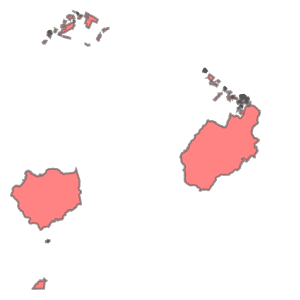

In [187]:
guy_geoms.wkt[1]

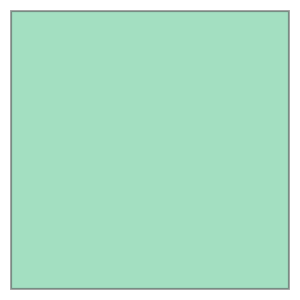

In [186]:
geom

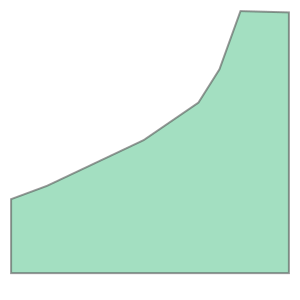

In [188]:
guy_geoms.wkt[1].intersection(geom)

In [189]:
print(geom)

POLYGON ((362000 536000, 362000 537000, 361000 537000, 361000 536000, 362000 536000))


In [144]:
guy_geoms.wkt[1].intersection(geom).area

561742.3281272135

In [145]:
geom.area

1000000.0

In [146]:
gc_list = df_ril[df_ril.type_com == "gc"].depcom.unique()

In [147]:
pc_list = df_ril[df_ril.type_com == "pc"].depcom.unique()

In [148]:
set(gc_list).intersection(pc_list)

set()

Ok pas d'intersection

In [149]:
fs.get('projet-slums-detection/Donnees/RIL/rca_geometry_ilots.rds', 'rca_geometry_ilots.rds')
result = pyreadr.read_r('rca_geometry_ilots.rds')
os.remove('rca_geometry_ilots.rds')
df_geom = result[None]

In [150]:
depcom_ilots = df_geom.depcom.unique()

In [151]:
depcom_ril = np.concatenate([gc_list, pc_list])

In [152]:
len(np.intersect1d(depcom_ilots, depcom_ril))

109

In [153]:
len(depcom_ril)

109

In [154]:
len(depcom_ilots)

131

In [155]:
list(set(depcom_ilots) - set(depcom_ril))

['97604',
 '97121',
 '97358',
 '97201',
 '97104',
 '97214',
 '97606',
 '97310',
 '97134',
 '97226',
 '97225',
 '97232',
 '97111',
 '97110',
 '97312',
 '97234',
 '97122',
 '97601',
 '97208',
 '97227',
 '97362',
 '97114']

Ok toutes les communes dans le RIL sont dans le df des ilots

In [156]:
def compute_recent_gr_geometries(dep):
    # Get data
    fs.get('projet-slums-detection/Donnees/RIL/rca_geometry_ilots.rds', 'rca_geometry_ilots.rds')
    result = pyreadr.read_r('rca_geometry_ilots.rds')
    os.remove('rca_geometry_ilots.rds')
    df_geom = result[None]
    df_geom['wkt'] = df_geom['wkt'].apply(wkt.loads)
    gdf = gpd.GeoDataFrame(df_geom, geometry="wkt", crs="EPSG:4326")
    
    # Filtering departement 
    gdf["dep"] = gdf.depcom.str[:3]
    gdf = gdf[gdf.dep == dep]
    gdf["wkt"] = [geom.buffer(0) for geom in gdf["wkt"]]
    
    # Return aggregated geometries
    return gdf.dissolve(by="gr").to_crs("epsg:" + dep_to_crs[dep])

In [244]:
def compute_old_gr_geometries(dep):
    # Get data
    fs.get('projet-slums-detection/Donnees/RIL/rca_geometry_ilots.rds', 'rca_geometry_ilots.rds')
    result = pyreadr.read_r('rca_geometry_ilots.rds')
    os.remove('rca_geometry_ilots.rds')
    df_geom = result[None]
    df_geom['wkt'] = df_geom['wkt'].apply(wkt.loads)
    gdf = gpd.GeoDataFrame(df_geom, geometry="wkt", crs="EPSG:4326")
    
    # Filtering departement 
    gdf["dep"] = gdf.depcom.str[:3]
    gdf = gdf[gdf.dep == dep]
    gdf["wkt"] = [geom.buffer(0) for geom in gdf["wkt"]]
    
    if dep == "976": 
        # Return aggregated geometries
        return gdf.dissolve(by="gr").to_crs("epsg:" + dep_to_crs[dep])
    else:
        gdf_pc = gdf[gdf.depcom.isin(pc_list)]
        gdf_gc = gdf[gdf.depcom.isin(gc_list)]
        # Missing cities in these lists...
        
        # Changing rotation group for small cities
        gdf_pc_copy = gdf_pc.copy()
        gdf_pc_copy["gr"] = ((((gdf_pc["gr"].astype(int)) - 2) % 5) + 1).astype(str)
        gdf_old = pd.concat([gdf_pc, gdf_gc])
        return gdf_old.dissolve(by="gr").to_crs("epsg:" + dep_to_crs[dep])

In [158]:
gdf[gdf.depcom.isin(pc_list)].shape

(2963, 5)

In [159]:
gdf[gdf.depcom.isin(pc_list)]

,depcom,gr,code_ilot,wkt,srid
34,97231,5,0100,"POLYGON ((-61.06416 14.54050, -61.06419 14.540...",4326
107,97219,4,0142,"POLYGON ((-61.22630 14.80790, -61.22623 14.807...",4326
111,97231,5,0101,"POLYGON ((-61.06773 14.53846, -61.06775 14.538...",4326
114,97231,5,0102,"POLYGON ((-61.06676 14.53870, -61.06681 14.538...",4326
173,97361,4,AC03,"POLYGON ((-53.93829 5.74322, -53.93907 5.74340...",4326
...,...,...,...,...,...
20260,97701,5,AX01,"POLYGON ((-62.80611 17.91035, -62.80612 17.910...",4326
20261,97701,5,AX04,"POLYGON ((-62.80733 17.90321, -62.80724 17.903...",4326
20262,97701,5,AX05,"POLYGON ((-62.80163 17.90505, -62.80102 17.904...",4326
20263,97701,5,AX06,"POLYGON ((-62.80623 17.90211, -62.80599 17.902...",4326


In [160]:
gdf[gdf.depcom.isin(gc_list)].shape

(16197, 5)

In [161]:
gdf.shape

(20266, 5)

In [245]:
compute_old_gr_geometries("971")

,wkt,depcom,code_ilot,srid,dep
gr,,,,,
1,"MULTIPOLYGON (((636605.669 1768262.492, 636626...",97101,CY03,4326,971
2,"MULTIPOLYGON (((636467.418 1767935.741, 636462...",97105,AN06,4326,971
3,"MULTIPOLYGON (((642361.942 1765135.972, 642347...",97119,AB03,4326,971
4,"MULTIPOLYGON (((640195.746 1766431.480, 640188...",97108,AL03,4326,971
5,"MULTIPOLYGON (((636327.105 1768179.117, 636331...",97106,AR06,4326,971


## Fonction pour filter les images labelisées RIL

In [203]:
from typing import Union

def has_non_valid_label(
    labeled_image,
    delta_threshold: int = 160
) -> bool:
    """
    Determines if image label is valid or not. 
    
    Args:
        labeled_image (Union[SegmentationLabeledSatelliteImage, DetectionLabeledSatelliteImage]): Labeled satellite image.

    Returns:
        bool: True if the image label is not valid, False otherwise.
    """
    if labeled_image.source == "RIL":
        return has_non_valid_ril_label(labeled_image, delta_threshold)
    elif labeled_image.source == "BDTOPO":
        return has_non_valid_bdtopo_label(labeled_image, delta_threshold)
    

def has_non_valid_ril_label(
    labeled_image,
    delta_threshold: int,
    area_pct_threshold: float
) -> bool:
    """
    Determines if RIL image label is valid or not. 
    
    Args:
        labeled_image (Union[SegmentationLabeledSatelliteImage, DetectionLabeledSatelliteImage]): Labeled satellite image.
        delta_threshold (int): Max number of days between labeling date and image date.
        area_pct_theshold (float): Threshold on the percentage of area of the time that should be contained in the rotation group.

    Returns:
        bool: True if the image label is not valid, False otherwise.
    """
    labeling_date = labeled_image.labeling_date
    image_date = labeled_image.satellite_image.date
    
    # Filter image if labeling date is too far from image date
    delta = labeling_date - image_date
    delta = abs(delta.days)
    if delta > delta_threshold:
        return True
    
    # Determine rotation group of labeling_year
    labeling_year = labeling_date.year
    gr = str(((labeling_year - 2018) % 5) + 1)
    
    # Rotation group geometry
    dep = labeled_image.satellite_image.dep
    if labeling_year > 2020:
        gr_geometries = compute_recent_gr_geometries(dep)
    else:
        gr_geometries = compute_old_gr_geometries(dep)
    gr_geometries = gr_geometries.reset_index()
    gr_geometry = gr_geometries[gr_geometries.gr == gr].wkt
    
    geom = box(*labeled_image.satellite_image.bounds)
    intersection_area = float(gr_geometry.intersection(geom).area)
    
    if intersection_area / geom.area < area_pct_threshold:
        return True
    
    # If checks passed, return False
    return False
    
def has_non_valid_bdtopo_label(
    labeled_image,
    delta_threshold: int
) -> bool:
    """
    Determines if BDTOPO image label is valid or not. 
    
    Args:
        labeled_image (Union[SegmentationLabeledSatelliteImage, DetectionLabeledSatelliteImage]): Labeled satellite image.

    Returns:
        bool: True if the image label is not valid, False otherwise.
    """
    return False


In [163]:
list_images[1]

In [164]:
filename = '../data/Cayenne/16bits/ORT_2022072050325085_U22N/ORT_2022072050325085_0353_0545_U22N_16Bits.jp2'

In [165]:
date = datetime.strptime(re.search(r'ORT_(\d{8})', filename).group(1), '%Y%m%d')
date

datetime.datetime(2022, 7, 20, 0, 0)

In [166]:
labeler = RILLabeler(date, dep="973")
mask = labeler.create_segmentation_label(list_images[1])

In [167]:
mask

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [168]:
labeled_image = SegmentationLabeledSatelliteImage(list_images[1], mask, "RIL", datetime.strptime(re.search(r'ORT_(\d{8})', filename).group(1), '%Y%m%d'))

In [205]:
has_non_valid_ril_label(labeled_image, 100000, 0.6)

True

## Exporting GR geometries

In [209]:
type(compute_recent_gr_geometries("971").reset_index()[["gr", "wkt"]])

geopandas.geodataframe.GeoDataFrame

In [210]:
compute_recent_gr_geometries("971").reset_index()[["gr", "wkt"]].rename(columns={"wkt": "geometry"})

,gr,geometry
0,1,"MULTIPOLYGON (((634541.286 1769980.752, 634547..."
1,2,"MULTIPOLYGON (((634644.412 1769874.001, 634659..."
2,3,"MULTIPOLYGON (((642361.942 1765135.972, 642347..."
3,4,"MULTIPOLYGON (((640195.746 1766431.480, 640188..."
4,5,"MULTIPOLYGON (((636327.105 1768179.117, 636331..."


In [222]:
type(compute_recent_gr_geometries("971").reset_index()[["gr", "wkt"]])

geopandas.geodataframe.GeoDataFrame

In [220]:
to_save = compute_recent_gr_geometries("971").reset_index()[["gr", "wkt"]]

In [224]:
to_save["wkt"] = to_save["wkt"]

In [225]:
type(to_save)

geopandas.geodataframe.GeoDataFrame

In [226]:
to_save.to_file("recent_gr_971.shp")

In [227]:
test_971 = gpd.read_file("recent_gr_971.shp")

In [228]:
test_971

,gr,geometry
0,1,"MULTIPOLYGON (((634541.286 1769980.752, 634547..."
1,2,"MULTIPOLYGON (((634644.412 1769874.001, 634659..."
2,3,"MULTIPOLYGON (((642361.942 1765135.972, 642347..."
3,4,"MULTIPOLYGON (((640195.746 1766431.480, 640188..."
4,5,"MULTIPOLYGON (((636327.105 1768179.117, 636331..."


In [229]:
test_971.geometry

0    MULTIPOLYGON (((634541.286 1769980.752, 634547...
1    MULTIPOLYGON (((634644.412 1769874.001, 634659...
2    MULTIPOLYGON (((642361.942 1765135.972, 642347...
3    MULTIPOLYGON (((640195.746 1766431.480, 640188...
4    MULTIPOLYGON (((636327.105 1768179.117, 636331...
Name: geometry, dtype: geometry

In [230]:
to_save.to_file("recent_gr_971.geojson", driver='GeoJSON')

In [231]:
test_971 = gpd.read_file("recent_gr_971.geojson")

In [232]:
test_971

,gr,geometry
0,1,"MULTIPOLYGON (((634541.286 1769980.752, 634547..."
1,2,"MULTIPOLYGON (((634644.412 1769874.001, 634659..."
2,3,"MULTIPOLYGON (((642361.942 1765135.972, 642347..."
3,4,"MULTIPOLYGON (((640195.746 1766431.480, 640188..."
4,5,"MULTIPOLYGON (((636327.105 1768179.117, 636331..."


In [233]:
test_971.geometry

0    MULTIPOLYGON (((634541.286 1769980.752, 634547...
1    MULTIPOLYGON (((634644.412 1769874.001, 634659...
2    MULTIPOLYGON (((642361.942 1765135.972, 642347...
3    MULTIPOLYGON (((640195.746 1766431.480, 640188...
4    MULTIPOLYGON (((636327.105 1768179.117, 636331...
Name: geometry, dtype: geometry

In [234]:
for dep in ["971", "972", "973", "974", "976", "977", "978"]:
    to_save = compute_recent_gr_geometries(dep).reset_index()[["gr", "wkt"]]
    to_save.to_file("to_s3/new_gr_" + dep + ".geojson", driver='GeoJSON')

In [246]:
for dep in ["971", "972", "973", "974", "976", "977", "978"]:
    to_save = compute_old_gr_geometries(dep).reset_index()[["gr", "wkt"]]
    to_save.to_file("to_s3/old_gr_" + dep + ".geojson", driver='GeoJSON')

## Class structure

In [ ]:
class RILFilter():
    """
    """
    
    def __init__(
        dep: str,
        delta_threshold: int,
        area_pct_threshold: float
    ):
        """
        """
        self.dep = dep
        self.delta_threshold = delta_threshold
        self.area_pct_threshold = area_pct_threshold
        
        environment = get_environment()
        old_gr_path = os.path.join(
            environment["bucket"],
            environment["sources"]["old_gr"][self.dep]
        )
        new_gr_path = os.path.join(
            environment["bucket"],
            environment["sources"]["new_gr"][self.dep]
        )
        self.old_gr_geometries = gpd.read_file()
        self.new_gr_geometries = gep.read_file()
        
    def validate(labeled_image):
        """
        """
        if not validate_labeling_date(labeled_image):
            return False
        return validate_rotation_group(labeled_image)

    def validate_labeling_date(labeled_image):
        """
        """
        labeling_date = labeled_image.labeling_date
        image_date = labeled_image.satellite_image.date
        
        # Filter image if labeling date is too far from image date
        delta = labeling_date - image_date
        delta = abs(delta.days)
        if delta > delta_threshold:
            return False
        return True
    
    def validate_rotation_group(labeled_image):
        """
        """
        # Determine rotation group of labeling year
        labeling_year = labeled_image.labeling_date.year
        gr = str(((labeling_year - 2018) % 5) + 1)

        # Rotation group geometry
        dep = labeled_image.satellite_image.dep
        if labeling_year > 2020:
            gr_geometries = self.new_gr_geometries
        else:
            gr_geometries = self.old_gr_geometries
        gr_geometry = gr_geometries[gr_geometries.gr == gr].geometry

        # Intersection between rotation group geometry and 
        # satellite image geometry
        geom = box(*labeled_image.satellite_image.bounds)
        intersection_area = float(gr_geometry.intersection(geom).area)

        # Validate if intersection area is large enough
        if intersection_area / geom.area < area_pct_threshold:
            return False
        return True